### **Initialization**

*Setting up Fast.ai Environment.*

In [1]:
# !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root_dir = "drive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

### **Downloading the Dependencies**

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai import *
from fastai.vision import *
from fastai.metrics import *

### **Getting the Data**

In [22]:
path =  Config.data_path()/'kaggle'
path.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('/root/.fastai/data/kaggle/.ipynb_checkpoints'),
 PosixPath('/root/.fastai/data/kaggle/train_v2.csv.zip')]

In [7]:
# !ls

data  drive  models


In [8]:
cd data

/root/.fastai/data


**Data Preparation**

In [9]:
# !unzip /content/data/kaggle/train_v2.csv.zip

Archive:  /content/data/kaggle/train_v2.csv.zip
  inflating: train_v2.csv            
   creating: __MACOSX/
  inflating: __MACOSX/._train_v2.csv  


In [13]:
# !apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [15]:
# !p7zip -d train-jpg.tar.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 629296207 bytes (601 MiB)

Extracting archive: train-jpg.tar.7z
--
Path = train-jpg.tar.7z
Type = 7z
Physical Size = 629296207
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train-jpg.tar                      1% - train-jpg.tar                      2% - train-jpg.tar                      3% - train-jpg.tar                      4% - train-jpg.tar                      5% - train-jpg.tar                      6% - train-jpg.tar

In [16]:
# !tar -xvf train-jpg.tar

Streaming output truncated to the last 5000 lines.
train-jpg/train_18344.jpg
train-jpg/train_27704.jpg
train-jpg/train_7979.jpg
train-jpg/train_13032.jpg
train-jpg/train_35254.jpg
train-jpg/train_30338.jpg
train-jpg/train_27364.jpg
train-jpg/train_20550.jpg
train-jpg/train_15082.jpg
train-jpg/train_34316.jpg
train-jpg/train_35048.jpg
train-jpg/train_35424.jpg
train-jpg/train_5090.jpg
train-jpg/train_5713.jpg
train-jpg/train_39060.jpg
train-jpg/train_11864.jpg
train-jpg/train_36277.jpg
train-jpg/train_14203.jpg
train-jpg/train_12909.jpg
train-jpg/train_12433.jpg
train-jpg/train_37809.jpg
train-jpg/train_6081.jpg
train-jpg/train_32372.jpg
train-jpg/train_34065.jpg
train-jpg/train_2274.jpg
train-jpg/train_20986.jpg
train-jpg/train_3903.jpg
train-jpg/train_4412.jpg
train-jpg/train_21703.jpg
train-jpg/train_5448.jpg
train-jpg/train_20568.jpg
train-jpg/train_5143.jpg
train-jpg/train_3306.jpg
train-jpg/train_17657.jpg
train-jpg/train_22337.jpg
train-jpg/train_5173.jpg
train-jpg/train_19085.jp

### **Multi-Classification**

In [24]:
path =  Config.data_path()
path.ls()

[PosixPath('/root/.fastai/data/.ipynb_checkpoints'),
 PosixPath('/root/.fastai/data/train_v2.csv'),
 PosixPath('/root/.fastai/data/train-jpg.tar'),
 PosixPath('/root/.fastai/data/__MACOSX'),
 PosixPath('/root/.fastai/data/kaggle'),
 PosixPath('/root/.fastai/data/train-jpg')]

In [25]:
df = pd.read_csv(path/"train_v2.csv")
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### **Creating ImageList with Fast.ai**

In [26]:
tfms = get_transforms(flip_vert=True, max_zoom=1.05, max_lighting=0.1, max_warp=0.)

In [27]:
np.random.seed(42)
src = (ImageList.from_csv(path, "train_v2.csv", folder="train-jpg", suffix='.jpg')
      .split_by_rand_pct(0.2)
      .label_from_df(label_delim=' '))

In [28]:
data = (src.transform(tfms, size=128)
      .databunch().normalize(imagenet_stats))

*Fast.ai has a show_batch function with helps in effective visualization.*

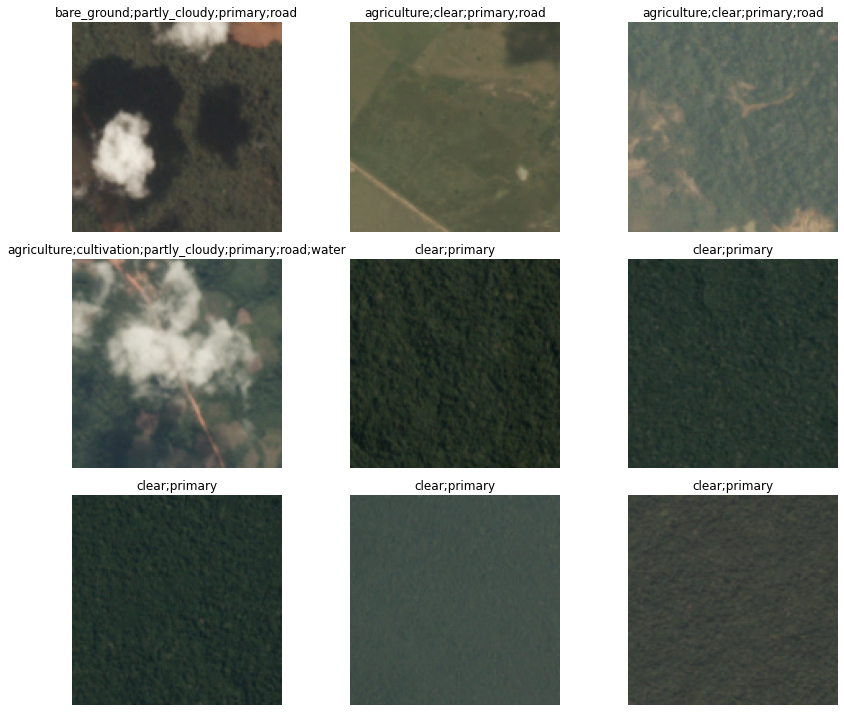

In [29]:
data.show_batch(rows=3, figsize=(12, 10))

In [30]:
arch = models.resnet50

In [31]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


*Using lr_find Function to find a good learning rate*

In [32]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


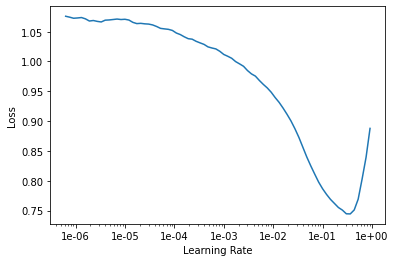

In [33]:
learn.recorder.plot()

*Now, we can fit the head of our network.*

In [34]:
lr = 0.01

In [35]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137064,0.117545,0.936577,0.898584,03:03
1,0.111242,0.099184,0.954235,0.912124,02:59
2,0.100405,0.093479,0.951568,0.917609,02:59
3,0.096728,0.087976,0.955586,0.925077,03:02
4,0.091489,0.087131,0.956807,0.925254,03:04


In [36]:
learn.save('stage-1-rn50')

*Let's fine tune the whole model.*

In [37]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


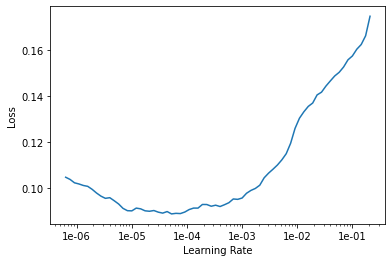

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(3, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098798,0.092464,0.951357,0.919879,03:01
1,0.093137,0.088134,0.957570,0.922809,03:01
2,0.085374,0.083362,0.959220,0.928546,03:00


In [40]:
learn.save('stage-2-rn50')

**Increasing the size of the Image**

In [41]:
data = (src.transform(tfms, size=256)
      .databunch()
      .normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [42]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


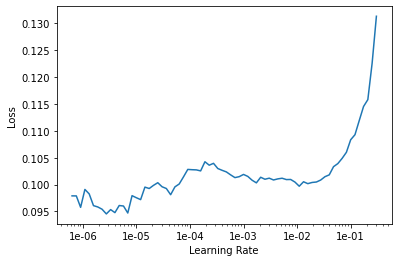

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
lr = 1e-03/2

In [45]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.090046,0.087741,0.954983,0.923927,05:39
1,0.086475,0.085499,0.955637,0.926023,05:46
2,0.087905,0.085101,0.956822,0.926226,05:48


In [46]:
learn.save("stage-1-256-rn50")

In [47]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


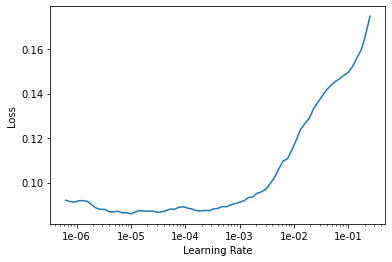

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(5, slice(1e-04, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086470,0.085822,0.955783,0.925746,06:11
1,0.089940,0.084499,0.956102,0.925868,06:07
2,0.085807,0.083428,0.958290,0.927118,06:14
3,0.080893,0.080924,0.959488,0.930852,06:15
4,0.077766,0.080509,0.958907,0.930683,06:16


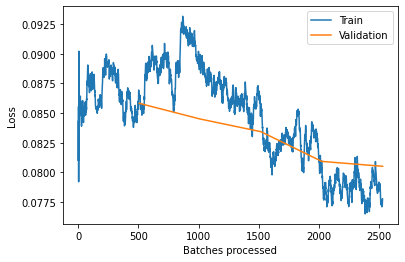

In [51]:
learn.recorder.plot_losses()

In [52]:
learn.save("stage-2-256-rn50")

In [54]:
learn.export()